In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras as kr
import random 
import model_prep_withFE
import model_prep_withoutFE
import operator
import lightgbm as lgb
import statsmodels.api as sm
import catboost as cb
import xgboost as xgb

from model_prep_withFE import prepare_data, get_features, get_bounds, get_interval_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from catboost import CatBoostRegressor, Pool

# Based on dataset used, use corresponding model_prep scripts to 
# load in respective cleaned dataset using one of the load functions below

# Load in pre-split data for data including feature engineering
X_train, X_test, y_train, y_test = prepare_data()
features = get_features()
train_bounds_5 = get_bounds(y_train, 5)
train_bounds_10 = get_bounds(y_train, 10)
test_bounds_5 = get_bounds(y_test, 5)
test_bounds_10 = get_bounds(y_test, 10)

# Load in pre-split data for original data excluding feature engineering
# X_train, X_test, y_train, y_test = model_prep_withoutFE.prepare_data()
# features = base_preprocessor.get_features()
# train_bounds_5 = get_bounds(y_train, 5)
# train_bounds_10 = get_bounds(y_train, 10)
# test_bounds_5 = get_bounds(y_test, 5)
# test_bounds_10 = get_bounds(y_test, 10)

Train data(range):
2019-04-11 21:50:04
2019-08-22 19:05:50
Test data(range):
2019-04-11 21:56:41
2019-08-22 19:06:11


### Linear Regression

In [5]:
# Linear Regression model (without regularization)
lm = LinearRegression()
lm.fit(X_train, y_train)

# Compute predictions
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Compute metrics
MSE = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Train Scores:")
print(MSE)
print(r2)

MSE = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test Scores:")
print(MSE)
print(r2)

# Display coefficients 
coef_df = pd.DataFrame(lm.coef_[0], features, columns=['Coefficient'])
coef_df

Train Scores:
102.45468708636352
0.8427514909864185
Test Scores:
102.64159711281981
0.8430075610452402


,Coefficient
travel_mins,-3.900686e+01
originpop,-3.903284e+11
destinationpop,4.880331e+11
days_to_holiday,1.675723e+00
days_from_holiday,-7.874908e-01
distance,2.002084e+13
month,-2.895189e+00
date,1.144547e+00
hour,4.281491e-02
minute,-3.271814e+00


In [7]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test)))

5% +/- limit:
0.302
0.293
10% +/- limit:
0.535175
0.53165


### Random Forest Regression

In [8]:
y_train = list(np.array(y_train).flatten())
y_test = list(np.array(y_test).flatten())

In [ ]:
# Perform cross validation to find best hyper parameters for random forest models
rfr = RandomForestRegressor()
parameters = {
            "n_estimators" : [50, 75, 150, 250, 300, 400],
            "max_depth": [None, 5, 8, 12, 15],
            "max_features": ['auto','sqrt']
            }

ran = RandomizedSearchCV(estimator=rfr, param_distributions=parameters, cv=5, n_jobs=-1, n_iter=10, random_state=0, verbose=2)
ran.fit(X_train, y_train)

# View best parameters to use in final model
ran.best_params_

In [9]:
# Train Random Forest model using best hyper parameters 
rf_150 = RandomForestRegressor(n_estimators=150, max_depth=None)
rf_150.fit(X_train, y_train)

# Compute predictions 
y_pred_train = rf_150.predict(X_train)
y_pred_test = rf_150.predict(X_test)

# Compute metrics
MSE = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Train Scores:")
print(MSE)
print(r2)

MSE = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Test Scores:")
print(MSE)
print(r2)

Train Scores:
2.4478998409971404
0.9962429381109045
Test Scores:
19.143323956317957
0.9707198913292429


In [10]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test)))

5% +/- limit:
0.9270625
0.76625
10% +/- limit:
0.9814
0.8911


In [ ]:
y_pred_train = rf_150.predict(X_train)
y_pred_test = rf_150.predict(X_test)
print(rf_150.score(X_test, y_test))
print(mean_squared_error(y_test, rf_150.predict(X_test)))
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test)))

### Gradient Boosting

#### GradientBoostingRegressor

In [11]:
model = GradientBoostingRegressor(n_estimators=500, max_depth=8, loss='ls', min_samples_split=2, learning_rate=0.01)

In [12]:
# Fit model 
model.fit(X_train, y_train)

# Compute MSE and R2 scores on testing
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, model.predict(X_test)))

0.9393857604651752
39.62956684446618


In [13]:
test_score = np.zeros((500,), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

Text(0, 0.5, 'Deviance')

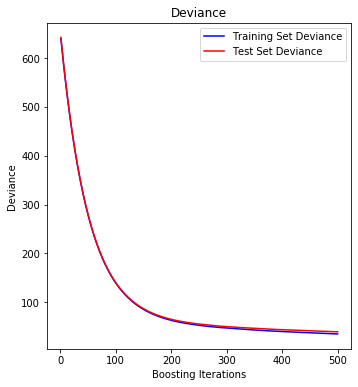

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(500) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(500) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Text(0.5, 1.0, 'Gradient Boost Actual vs. Predicted Values')

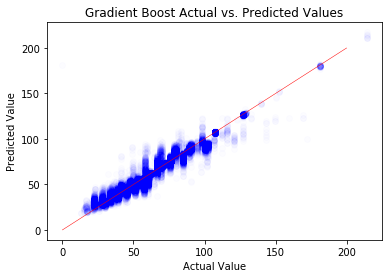

In [17]:
y_pred_train_gb = model.predict(X_train)
y_pred_test_gb = model.predict(X_test)
plt.plot(y_test, y_preds_test_gb, 'bo', alpha = 0.01)
plt.plot([0, 200], [0, 200], color = 'red', linewidth = 0.5)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Gradient Boost Actual vs. Predicted Values")

In [18]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train_gb)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test_gb)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train_gb)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test_gb)))

5% +/- limit:
0.53325
0.52765
10% +/- limit:
0.7411
0.7302


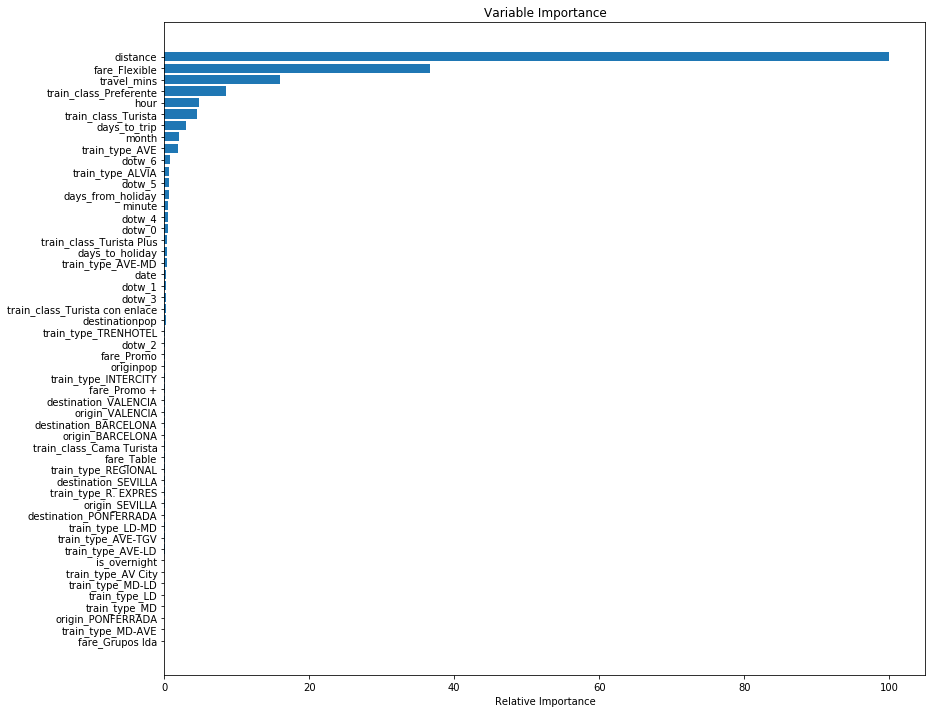

In [19]:
# Calculate variable importance for mode
indices = np.array(list(range(len(features))))
features = np.array(features)[indices.astype(int)]
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(30, 12))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### XGBoost

In [20]:
xg_train = pd.DataFrame(X_train)
xg_test = pd.DataFrame(X_test)
xg_train.columns = features
xg_test.columns = features

In [22]:
# Perform cross validation to find best hyperparameters for model
cv_params = {'max_depth': [2, 4, 6, 8], 'eta': [1, 0.5],'lambda': [1, 3, 5], 'learning_rate' : [0.2, 0.1, 0.05]}
ind_params = {'objective': 'reg:squarederror', 'seed': 0}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, cv=3, n_jobs=-1)

In [ ]:
gs_XGBM = optimized_GBM.fit(xg_train, y_train)

In [32]:
# Extract best parameters to use in final model
bst = optimized_GBM.best_estimator_

In [21]:
# Fit model
bst.fit(X_train, y_train)

NameError: name 'bst' is not defined

In [35]:
y_preds_bst = bst.predict(X_test)
print(r2_score(y_test, y_preds_bst))
print(mean_squared_error(y_test, y_preds_bst))
print(get_interval_accuracy_score(test_bounds_5, y_preds_bst))
print(get_interval_accuracy_score(test_bounds_10, y_preds_bst))

0.9575070215323106
27.374443208791437
0.5947
0.8009


#### CatBoost

In [ ]:
# Perform cross validation to identify best hyper paremeters for model
params = {'iterations': [300, 500, 1000],
        'learning_rate': [0.2, 0.1, 0.01],
        'depth': [6, 8, 10],
        'l2_leaf_reg': [1, 3, 5]}
cbm = CatBoostRegressor()

gs_result = cbm.grid_search(params, X=X_train, y=y_train, plot=True)

In [6]:
# Use best hyper paremeters for model
cbe = cb.CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=10, l2_leaf_reg=1)

In [7]:
# Fit model
cbe.fit(X_train, y_train)
cbe_y_preds_test = cbe.predict(X_test)

0:	learn: 21.2407914	total: 82.9ms	remaining: 1m 22s
1:	learn: 17.9189449	total: 96ms	remaining: 47.9s
2:	learn: 15.3010386	total: 107ms	remaining: 35.6s
3:	learn: 13.3669963	total: 118ms	remaining: 29.4s
4:	learn: 11.8199904	total: 131ms	remaining: 26s
5:	learn: 10.6805460	total: 142ms	remaining: 23.5s
6:	learn: 9.8837011	total: 155ms	remaining: 22s
7:	learn: 9.2659509	total: 168ms	remaining: 20.9s
8:	learn: 8.7986001	total: 182ms	remaining: 20s
9:	learn: 8.4390953	total: 198ms	remaining: 19.6s
10:	learn: 8.1792647	total: 211ms	remaining: 19s
11:	learn: 7.9938386	total: 226ms	remaining: 18.6s
12:	learn: 7.8145545	total: 238ms	remaining: 18.1s
13:	learn: 7.7007093	total: 250ms	remaining: 17.6s
14:	learn: 7.5663350	total: 262ms	remaining: 17.2s
15:	learn: 7.4542949	total: 274ms	remaining: 16.8s
16:	learn: 7.3560923	total: 287ms	remaining: 16.6s
17:	learn: 7.2734348	total: 302ms	remaining: 16.5s
18:	learn: 7.2128038	total: 321ms	remaining: 16.6s
19:	learn: 7.1475209	total: 335ms	remainin

168:	learn: 4.4815792	total: 2.11s	remaining: 10.4s
169:	learn: 4.4768194	total: 2.13s	remaining: 10.4s
170:	learn: 4.4666479	total: 2.14s	remaining: 10.4s
171:	learn: 4.4588311	total: 2.15s	remaining: 10.3s
172:	learn: 4.4557100	total: 2.16s	remaining: 10.3s
173:	learn: 4.4473295	total: 2.17s	remaining: 10.3s
174:	learn: 4.4431663	total: 2.18s	remaining: 10.3s
175:	learn: 4.4362352	total: 2.19s	remaining: 10.3s
176:	learn: 4.4310369	total: 2.2s	remaining: 10.2s
177:	learn: 4.4226810	total: 2.21s	remaining: 10.2s
178:	learn: 4.4151635	total: 2.23s	remaining: 10.2s
179:	learn: 4.4058403	total: 2.23s	remaining: 10.2s
180:	learn: 4.4009938	total: 2.25s	remaining: 10.2s
181:	learn: 4.3960151	total: 2.26s	remaining: 10.1s
182:	learn: 4.3874652	total: 2.27s	remaining: 10.1s
183:	learn: 4.3813074	total: 2.28s	remaining: 10.1s
184:	learn: 4.3750265	total: 2.29s	remaining: 10.1s
185:	learn: 4.3651679	total: 2.3s	remaining: 10.1s
186:	learn: 4.3573436	total: 2.31s	remaining: 10.1s
187:	learn: 4.

327:	learn: 3.5903455	total: 3.95s	remaining: 8.1s
328:	learn: 3.5876276	total: 3.97s	remaining: 8.09s
329:	learn: 3.5846982	total: 3.98s	remaining: 8.07s
330:	learn: 3.5821777	total: 3.99s	remaining: 8.06s
331:	learn: 3.5787155	total: 4s	remaining: 8.04s
332:	learn: 3.5742604	total: 4.01s	remaining: 8.03s
333:	learn: 3.5685340	total: 4.02s	remaining: 8.01s
334:	learn: 3.5664403	total: 4.03s	remaining: 8s
335:	learn: 3.5617846	total: 4.04s	remaining: 7.98s
336:	learn: 3.5582012	total: 4.05s	remaining: 7.97s
337:	learn: 3.5521767	total: 4.06s	remaining: 7.95s
338:	learn: 3.5498921	total: 4.07s	remaining: 7.94s
339:	learn: 3.5464505	total: 4.08s	remaining: 7.92s
340:	learn: 3.5454732	total: 4.09s	remaining: 7.91s
341:	learn: 3.5430915	total: 4.11s	remaining: 7.9s
342:	learn: 3.5397241	total: 4.12s	remaining: 7.88s
343:	learn: 3.5378643	total: 4.13s	remaining: 7.87s
344:	learn: 3.5360977	total: 4.14s	remaining: 7.86s
345:	learn: 3.5326042	total: 4.15s	remaining: 7.84s
346:	learn: 3.531793

493:	learn: 3.0779210	total: 5.8s	remaining: 5.94s
494:	learn: 3.0765403	total: 5.81s	remaining: 5.93s
495:	learn: 3.0741789	total: 5.82s	remaining: 5.92s
496:	learn: 3.0721103	total: 5.84s	remaining: 5.91s
497:	learn: 3.0699748	total: 5.85s	remaining: 5.89s
498:	learn: 3.0654609	total: 5.86s	remaining: 5.88s
499:	learn: 3.0629468	total: 5.87s	remaining: 5.87s
500:	learn: 3.0615313	total: 5.88s	remaining: 5.85s
501:	learn: 3.0596559	total: 5.89s	remaining: 5.84s
502:	learn: 3.0557760	total: 5.9s	remaining: 5.83s
503:	learn: 3.0534857	total: 5.92s	remaining: 5.82s
504:	learn: 3.0472657	total: 5.93s	remaining: 5.81s
505:	learn: 3.0456101	total: 5.94s	remaining: 5.79s
506:	learn: 3.0443329	total: 5.95s	remaining: 5.78s
507:	learn: 3.0430068	total: 5.96s	remaining: 5.77s
508:	learn: 3.0385342	total: 5.97s	remaining: 5.76s
509:	learn: 3.0360299	total: 5.98s	remaining: 5.75s
510:	learn: 3.0344170	total: 5.99s	remaining: 5.73s
511:	learn: 3.0315263	total: 6s	remaining: 5.72s
512:	learn: 3.029

660:	learn: 2.7264142	total: 7.63s	remaining: 3.91s
661:	learn: 2.7246938	total: 7.64s	remaining: 3.9s
662:	learn: 2.7238704	total: 7.65s	remaining: 3.89s
663:	learn: 2.7212744	total: 7.67s	remaining: 3.88s
664:	learn: 2.7194452	total: 7.68s	remaining: 3.87s
665:	learn: 2.7182537	total: 7.69s	remaining: 3.85s
666:	learn: 2.7159675	total: 7.7s	remaining: 3.84s
667:	learn: 2.7153652	total: 7.71s	remaining: 3.83s
668:	learn: 2.7140759	total: 7.72s	remaining: 3.82s
669:	learn: 2.7129542	total: 7.73s	remaining: 3.81s
670:	learn: 2.7120758	total: 7.74s	remaining: 3.79s
671:	learn: 2.7085922	total: 7.75s	remaining: 3.78s
672:	learn: 2.7073581	total: 7.76s	remaining: 3.77s
673:	learn: 2.7053413	total: 7.78s	remaining: 3.76s
674:	learn: 2.7041332	total: 7.79s	remaining: 3.75s
675:	learn: 2.7030820	total: 7.8s	remaining: 3.74s
676:	learn: 2.6990242	total: 7.81s	remaining: 3.73s
677:	learn: 2.6973429	total: 7.82s	remaining: 3.71s
678:	learn: 2.6954847	total: 7.84s	remaining: 3.71s
679:	learn: 2.6

820:	learn: 2.4763218	total: 9.46s	remaining: 2.06s
821:	learn: 2.4750592	total: 9.48s	remaining: 2.05s
822:	learn: 2.4727451	total: 9.49s	remaining: 2.04s
823:	learn: 2.4720704	total: 9.5s	remaining: 2.03s
824:	learn: 2.4702342	total: 9.51s	remaining: 2.02s
825:	learn: 2.4689652	total: 9.52s	remaining: 2.01s
826:	learn: 2.4683259	total: 9.54s	remaining: 2s
827:	learn: 2.4671158	total: 9.55s	remaining: 1.98s
828:	learn: 2.4667289	total: 9.56s	remaining: 1.97s
829:	learn: 2.4647776	total: 9.57s	remaining: 1.96s
830:	learn: 2.4633728	total: 9.58s	remaining: 1.95s
831:	learn: 2.4609916	total: 9.6s	remaining: 1.94s
832:	learn: 2.4595608	total: 9.61s	remaining: 1.93s
833:	learn: 2.4576759	total: 9.62s	remaining: 1.91s
834:	learn: 2.4564120	total: 9.63s	remaining: 1.9s
835:	learn: 2.4551678	total: 9.64s	remaining: 1.89s
836:	learn: 2.4530012	total: 9.66s	remaining: 1.88s
837:	learn: 2.4518239	total: 9.67s	remaining: 1.87s
838:	learn: 2.4508804	total: 9.69s	remaining: 1.86s
839:	learn: 2.4500

990:	learn: 2.2525883	total: 11.5s	remaining: 104ms
991:	learn: 2.2513027	total: 11.5s	remaining: 92.8ms
992:	learn: 2.2502772	total: 11.5s	remaining: 81.2ms
993:	learn: 2.2490751	total: 11.5s	remaining: 69.6ms
994:	learn: 2.2482424	total: 11.5s	remaining: 58ms
995:	learn: 2.2471563	total: 11.6s	remaining: 46.4ms
996:	learn: 2.2458767	total: 11.6s	remaining: 34.8ms
997:	learn: 2.2432493	total: 11.6s	remaining: 23.2ms
998:	learn: 2.2417649	total: 11.6s	remaining: 11.6ms
999:	learn: 2.2395046	total: 11.6s	remaining: 0us


In [8]:
# Compute R2, MSE, and accuracy scores
print(r2_score(y_test, cbe_y_preds_test))
print(mean_squared_error(y_test, cbe_y_preds_test))
print(get_interval_accuracy_score(test_bounds_5, cbe_y_preds_test))
print(get_interval_accuracy_score(test_bounds_10, cbe_y_preds_test))

0.9715307594845826
18.34019726998661
0.70505
0.87265


### Neural Networks

In [1]:
# Flatten target variable to use in NN models
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Define functions for NN models, running models, etc
def base_model():
    model = Sequential()
    model.add(Dense(10, input_dim = 49, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))
    adam = Adam()
    # Compile
    model.compile(loss = 'mean_squared_error', optimizer=adam, metrics =['mean_squared_error'])
    return model

def run_network(xtrain, xtest, ytrain, ytest, model, epochs, batch):
    model.fit(xtrain, ytrain, nb_epoch = epochs, batch_size = batch,
              validation_data = (xtest, ytest),verbose = 2)
    return model

# Change the number of layers but hold the number of hidden neurons constant
def change_layers_neurons(numlayers, numneurons):
    model = Sequential()
    model.add(Dense(numneurons, input_dim = 49, kernel_initializer = 'normal', activation = 'relu'))
    for x in range(1- numlayers):
        model.add(Dense(numneurons, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation = 'linear'))
    adam = Adam()
    model.compile(loss = 'mean_squared_error', optimizer=adam, metrics =['mean_squared_error'])
    return model

basemodel = base_model()
basemodel.summary()

# Run Network for Base Model
run_network(X_train, X_test, y_train, y_test, basemodel, 10,20)

# Create more networks hold number of neurons/layer constant
 
# 5 layers
model1 = change_layers_neurons(5, 10)
run_network(X_train, X_test, y_train, y_test, model1, 10,20)
run_network(X_train, X_test, y_train, y_test, model1, 10,3)

# 10 layers
model2 = change_layers_neurons(10, 10)
run_network(X_train, X_test, y_train, y_test, model2, 10,20)

# 15 layers
model3 = change_layers_neurons(15, 10)
run_network(X_train, X_test, y_train, y_test, model3, 10,20)

# 25 layers
model4 = change_layers_neurons(25, 10)
run_network(X_train, X_test, y_train, y_test, model3, 10,20)

# Create layers with more neurons, hold number of layers constant

# 15 neurons
model5 = change_layers_neurons(3, 15)
run_network(X_train, X_test, y_train, y_test, model5, 10,20)

# 20 neurons
model6 = change_layers_neurons(3, 20)
run_network(X_train, X_test, y_train, y_test, model6, 10,20)

# 30 neurons
model7 = change_layers_neurons(3, 30)
run_network(X_train, X_test, y_train, y_test, model7, 10,20)

## Model 7 performs the best and will be used for model predictions and evaluation below

NameError: name 'np' is not defined

In [9]:
# Compute predictions using best model training on neural network (model 7)
y_pred_train_nn = model7.predict(X_train)
y_pred_test_nn = model7.predict(X_test)

# Compute R2 and MSE on test data
print(r2_score(y_test, y_preds_test_nn))
print(mean_squared_error(y_test, y_preds_test_nn))

NameError: name 'basemodel' is not defined

In [ ]:
# Compute accuracy scores for 5% and 10% intervals
print("5% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_5, y_pred_train_nn)))
print(np.mean(get_interval_accuracy_score(test_bounds_5, y_pred_test_nn)))
print("10% +/- limit:")
print(np.mean(get_interval_accuracy_score(train_bounds_10, y_pred_train_nn)))
print(np.mean(get_interval_accuracy_score(test_bounds_10, y_pred_test_nn)))